# CS680 Project



**Description**

This notebook contains implementation of my CS680 project. I compare ResNets and DenseNets performance on breast cancer MRI images. ResNet-152V2 and DenseNet-169 achieve the best validation accuracy of 99.65%.

Dataset is publicly available on [Kaggle](https://www.kaggle.com/datasets/uzairkhan45/breast-cancer-patients-mris).

**Dependencies**

- numpy: 1.21.6
- pandas: 1.3.5
- scipy: 1.7.3
- matplotlib: 3.2.2
- tqdm: 4.64.1
- tensorflow: 2.9.2
- keras: 2.9.0
- scikit-learn: 1.0.2

**Table of content**

>[CS680 Project](#scrollTo=gHO89pYSQJJE)

>[Setup](#scrollTo=mh9-UAMVNtgH)

>[Load Data](#scrollTo=o8bn2ufHN2bI)

>>[Load Images from Source](#scrollTo=D-l2N-y7RJoB)

>>[Preprocessing (optional)](#scrollTo=jwfjo_w8T-dz)

>>[Data Augmentation](#scrollTo=Et0Ow-c4UBNo)

>[Training](#scrollTo=VOZ59z0hUMac)

>>[Select a Model](#scrollTo=OL8D8L5zUPJT)

>>[Training & Evaluation](#scrollTo=PFY-WUtsUdbY)

>[Prediction](#scrollTo=_jBn1A9AVTN5)

>>[Best validation accuracy](#scrollTo=2JzWMbPyVZOs)

>>[Make predictions on test set](#scrollTo=bDcYu6huVc-o)

>>[Confusion matrix](#scrollTo=SS06D8xzVlAd)

>>[Classification Report](#scrollTo=c-rCslliVs1X)

>>[ROC Curve](#scrollTo=Ij5DPU2gVxWu)

>>[Inspect Predicted Images](#scrollTo=-YudcqJrV26g)



# Setup

In [2]:
import os
import json
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from tqdm import tqdm

import cv2
from PIL import Image

import tensorflow as tf
from keras import layers
from keras.applications import ResNet50, ResNet50V2, ResNet101V2, ResNet152V2, DenseNet121, DenseNet169, DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn import metrics

import gc # Garbage Collector
from functools import partial

from collections import Counter
import itertools


%matplotlib inline

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Change working directory if necessary
os.chdir("drive/MyDrive/CS680Proj")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content/drive/MyDrive/CS680Proj


In [ ]:
"""
train/Healthy : 700 images
train/Sick : 700 images
validation/Healthy : 40 images
validation/Sick : 40 images
"""

TRAIN_PATH= "./MRI_data/train"
TEST_PATH="./MRI_data/validation"
BATCH_SIZE = 16

# Load Data

## Load Images from Source

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        # print(IMAGE_NAME)
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)

        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

healthy_train = np.array(Dataset_loader(f'{TRAIN_PATH}/Healthy',224))
sick_train = np.array(Dataset_loader(f'{TRAIN_PATH}/Sick',224))
sick_test_1 = np.array(Dataset_loader(f'{TEST_PATH}/Healthy',224)) # lable in dataset is wrong
sick_test_2 = np.array(Dataset_loader(f'{TEST_PATH}/Sick',224))


100%|██████████| 40/40 [00:00<00:00, 319.75it/s]


In [ ]:
np.random.seed(2)

""" Process data from the source """
# Merge sick data
healthy_all_x = np.copy(healthy_train)
healthy_all_y = np.zeros(len(healthy_all_x))

sick_all_x = np.concatenate((sick_train, sick_test_1, sick_test_2), axis = 0)
sick_all_y = np.ones(len(sick_all_x))

# split train and test set from training set
healthy_train, healthy_test, healthy_train_label, healthy_test_label = train_test_split(
    healthy_all_x, 
    healthy_all_y,
    test_size=0.05, 
    random_state=0
)

sick_train, sick_test, sick_train_label, sick_test_label = train_test_split(
    sick_all_x, 
    sick_all_y,
    test_size=0.05, 
    random_state=0
)

# Merge data 
X_train = np.concatenate((healthy_train, sick_train), axis = 0)
Y_train = np.concatenate((healthy_train_label, sick_train_label), axis = 0)
X_test = np.concatenate((healthy_test, sick_test), axis = 0)
Y_test = np.concatenate((healthy_test_label, sick_test_label), axis = 0)

# Shuffle train data
idx_list = np.arange(X_train.shape[0])
np.random.shuffle(idx_list)
X_train = X_train[idx_list]
Y_train = Y_train[idx_list]

# Shuffle test data
idx_list = np.arange(X_test.shape[0])
np.random.shuffle(idx_list)
X_test = X_test[idx_list]
Y_test = Y_test[idx_list]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
# split validation set from training set
x_train, x_validation, y_train, y_validation = train_test_split(
    X_train, 
    Y_train, 
    test_size=0.2, 
    random_state=0
)

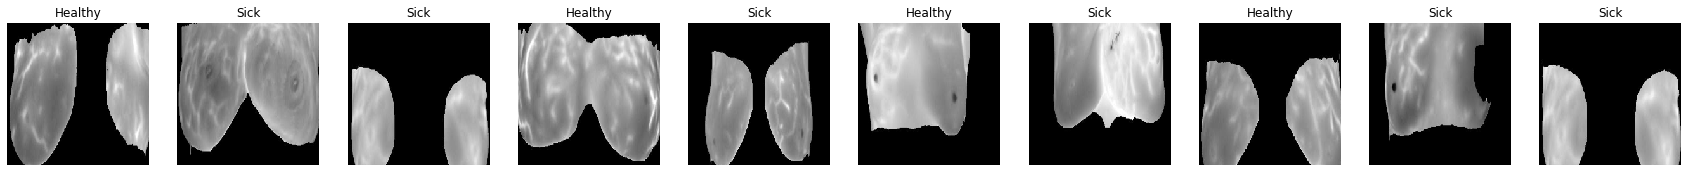

In [ ]:
# # Display first 15 images of moles, and how they are classified
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 1

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Healthy')
    else:
        ax.title.set_text('Sick')
    plt.imshow(x_train[i], interpolation='nearest')
    plt.axis('off')
plt.show()


## Preprocessing (optional)

In [ ]:
# x_train = tf.keras.applications.densenet.preprocess_input(x_train)
# x_validation = tf.keras.applications.densenet.preprocess_input(x_validation)
# X_test = tf.keras.applications.densenet.preprocess_input(X_test)


## Data Augmentation

In [ ]:
# Using original generator
train_generator = ImageDataGenerator(
    zoom_range = 0.2,  # zoom [0.8, 1.2]
    rotation_range = 90,
    horizontal_flip = True,  # randomly flip images horizontally
    vertical_flip = True,  # randomly flip images vertically
)

# Training


## Select a Model
Use ***model_option*** to choose which DenseNet model to train

Options are
- "DenseNet121" 
- "DenseNet169" 
- "DenseNet201"
- "ResNet50V2" 
- "ResNet101V2" 
- "ResNet152V2"

In [ ]:
model_option = "DenseNet201"

K.clear_session()
gc.collect()

def build_CNN_model(backbone, learning_rate=1e-4):
    model = Sequential()
    model.add(backbone)

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics= ['accuracy']
    )
    
    return model


network_architecture = None

if model_option == "DenseNet121":
    network_architecture = DenseNet121(
        weights='imagenet', 
        include_top=False,
        input_shape=(224,224,3)
    )
elif model_option == "DenseNet169":
    network_architecture = DenseNet169(
        weights='imagenet', 
        include_top=False,
        input_shape=(224,224,3)
    )
elif:
    network_architecture = DenseNet201(
        weights='imagenet', 
        include_top=False,
        input_shape=(224,224,3)
    )
elif model_option == "ResNet50V2":
    network_architecture = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )
elif model_option == "ResNet101V2":
    network_architecture = ResNet101V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )
else:
    network_architecture = ResNet152V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )

model = build_CNN_model(network_architecture ,learning_rate = 1e-4)
model.summary()


# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath=f"{model_option}.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

## Training & Evaluation

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch = math.ceil(x_train.shape[0]/BATCH_SIZE),
    epochs = 40,
    validation_data=(x_validation, y_validation),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/40
71/71 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.6308
Epoch 1: val_accuracy improved from -inf to 0.63121, saving model to DenseNet201.best.hdf5
71/71 [==============================] - 69s 605ms/step - loss: 0.7038 - accuracy: 0.6308 - val_loss: 0.6768 - val_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 2/40
71/71 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.7544
Epoch 2: val_accuracy improved from 0.63121 to 0.67376, saving model to DenseNet201.best.hdf5
71/71 [==============================] - 29s 411ms/step - loss: 0.5326 - accuracy: 0.7544 - val_loss: 0.5835 - val_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 3/40
71/71 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8238
Epoch 3: val_accuracy did not improve from 0.67376
71/71 [==============================] - 24s 341ms/step - loss: 0.4233 - accuracy: 0.8238 - val_loss: 0.6092 - val_accuracy: 0.6702 - lr: 1.0000e-04
Epoch 4/40
71/71 [=================

In [ ]:
with open(f'{model_option}_history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df.head() 

,loss,accuracy,val_loss,val_accuracy,lr
0,0.703798,0.630783,0.676806,0.631206,0.0001
1,0.532578,0.754448,0.583535,0.673759,0.0001
2,0.423258,0.823843,0.609181,0.670213,0.0001
3,0.305683,0.879004,0.323577,0.836879,0.0001
4,0.226255,0.916370,0.516472,0.808511,0.0001


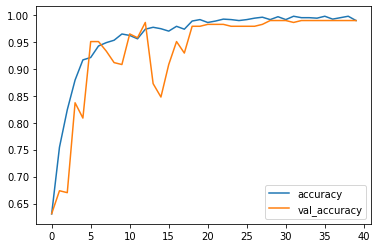

In [ ]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.savefig(f"{model_option}_accuracy.png")

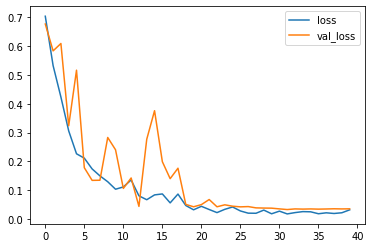

In [ ]:
history_df[['loss', 'val_loss']].plot()
plt.savefig(f"{model_option}_loss.png")

# Prediction

In [ ]:
model.load_weights(f"{model_option}.best.hdf5")

## Best Validation Accuracy

In [ ]:
Y_validation_pred = model.predict(x_validation)
accuracy_score(np.argmax(y_validation, axis=1), np.argmax(Y_validation_pred, axis=1))

9/9 [==============================] - 5s 146ms/step


0.9893617021276596

## Make Predictions on Test Set

In [ ]:
Y_pred = model.predict(X_test)
tta_steps = math.ceil(len(X_test)/BATCH_SIZE)
predictions = []

for i in range(tta_steps):
    preds = model.predict(
        train_generator.flow(
            X_test, 
            batch_size=BATCH_SIZE, 
            shuffle=False
        ),
        steps = math.ceil(len(X_test)/BATCH_SIZE)
    )
    
    predictions.append(preds)
    # gc.collect()
    
# test time augmentation
Y_pred_tta = np.mean(predictions, axis=0)

5/5 [==============================] - 1s 168ms/step


In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.9864864864864865

In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.9864864864864865

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_option}_{title}.png")

Confusion matrix, without normalization
[[34  1]
 [ 0 39]]


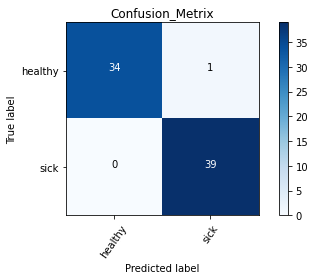

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label = ['healthy', 'sick']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion_Metrix')

Confusion matrix, without normalization
[[34  1]
 [ 0 39]]


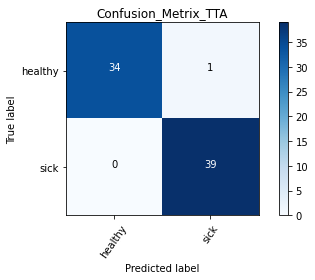

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['healthy', 'sick']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion_Metrix_TTA')

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.97      1.00      0.99        39

    accuracy                           0.99        74
   macro avg       0.99      0.99      0.99        74
weighted avg       0.99      0.99      0.99        74



## ROC Curve

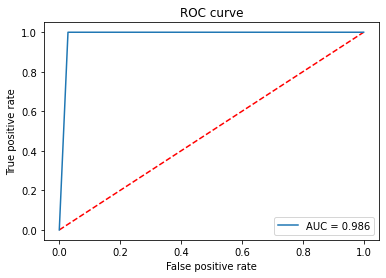

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig(f"{model_option}_ROC.png")
# plt.close()

## Inspect Predicted Images

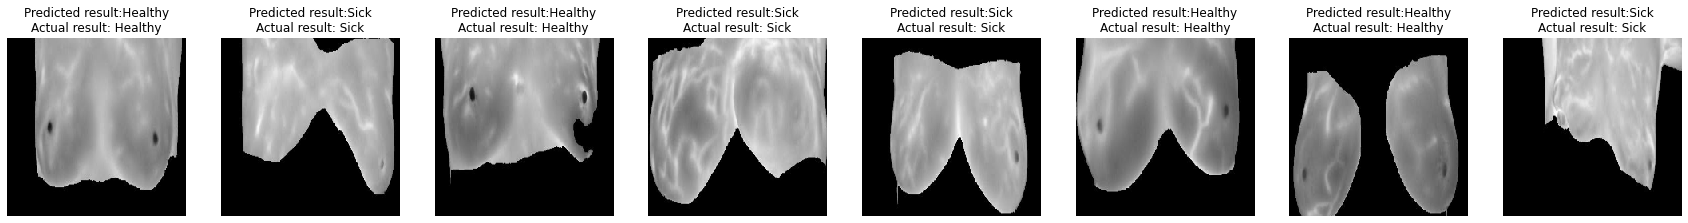

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of healthy
fig=plt.figure(figsize=(30, 10))
columns = 8
rows = 1

def Transfername(namecode):
    if namecode==0:
        return "Healthy"
    else:
        return "Sick"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
    plt.axis('off')
plt.show()


<ipython-input-28-82dd6dcc6cb1>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(rows, columns, i+1)


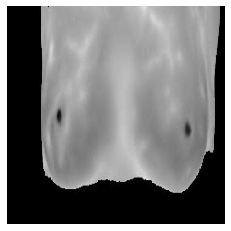

In [ ]:
for i in range(len(mis_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
    plt.axis('off')
plt.show()

References:

- [Example notebook](https://github.com/abhinavsagar/breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb)

- [Keras doc](https://keras.io/api/applications/)